* Import external libraries:

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import matplotlib.collections
plt.style.use(['science', 'notebook'])
import numpy as np
import scipy as scy
from scipy.spatial import cKDTree

* Creating a particle class:

In [44]:
class Particle:
    def __init__(self, r, x, y, vx, vy):
        self.r = r
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        
    def __repr__(self):
        return str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.x, self.y, self.vx, self.vy))

In [45]:
box = [20, 20]
n_particles = 50
vel = 0.5  # initial velocity
angle = np.random.uniform(low=0, high=2*np.pi, size=n_particles)  # random initial directions
radius = 0.5
r = np.random.uniform(low=radius, high=box[0]-radius, size=(2, n_particles))  # random initial positions
ps = [Particle(radius, r[0][j], r[1][j], vel*np.cos(angle[j]), vel*np.sin(angle[j])) for j in range(n_particles)]
v = np.zeros((2,n_particles))
for i in range(n_particles):
    v[0][i] = ps[i].vx
    v[1][i] = ps[i].vy

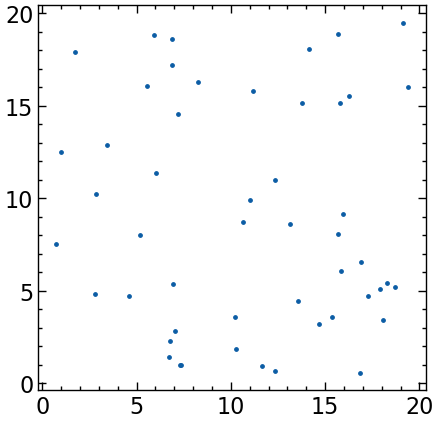

In [46]:
plt.figure(figsize=(5, 5))
plt.scatter(r[0], r[1], s=6)
plt.show()

In [47]:
def move(p,dt):
    """time integrator for numerical, stepwise solution of equation of motion with a discrete time step dt"""
    p.x = p.x + p.vx*dt
    p.y = p.y + p.vy*dt
    return p


def reflect(p):
    """box reflection"""
    if (p.x + p.r) >= box[0]:
        p.vx = p.vx * (-1)
    if (p.x - p.r) <= 0:
        p.vx = p.vx * (-1)
    if (p.y + p.r) >= box[1]:
        p.vy = p.vy * (-1)
    if (p.y - p.r) <= 0:
        p.vy = p.vy * (-1)
    return p

In [48]:
steps = 2000
data_traj = np.zeros((n_particles, 4, steps))
for j in range(3):
    p1 = ps[j]
    for i in range(steps):
        reflect(p1)
        move(p1,1)
        data_traj[j][:,i] = [p1.x, p1.y, p1.vx, p1.vy]

* Simulation with 3 particles without collision

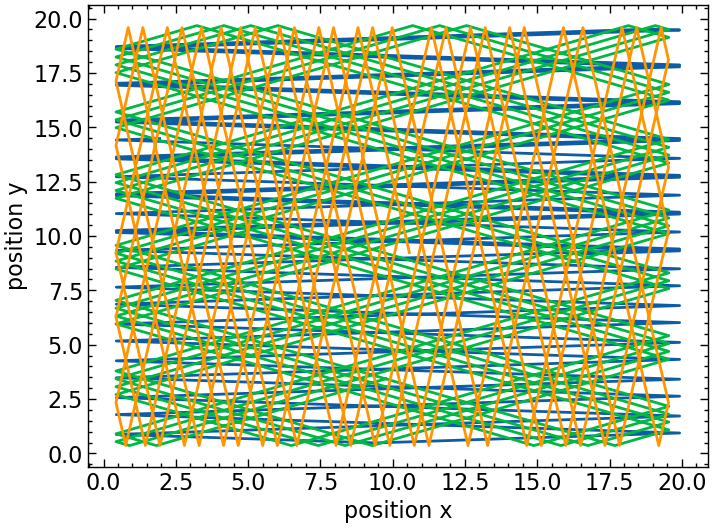

In [49]:
for i in range(3):
    plt.plot(data_traj[i][0], data_traj[i][1], '-')

plt.xlabel('position x')
plt.ylabel('position y')
plt.show()

* Velocities after collision:
$$\vec{v}_1^{\text{new}} = \vec{v}_1 - \frac{(\vec{v}_1 - \vec{v}_2) \cdot (\vec{r}_1 - \vec{r}_2)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_1 - \vec{r}_2)$$
$$\vec{v}_2^{\text{new}} = \vec{v}_2 - \frac{(\vec{v}_2 - \vec{v}_1) \cdot (\vec{r}_2 - \vec{r}_1)}{|\vec{r}_1 - \vec{r}_2|^2} (\vec{r}_2 - \vec{r}_1)$$

* Functions used for simulation

In [50]:
def compute_new_v(v1, v2, r1, r2):
    """calculates velocity after collision"""
    v1_new = v1 - np.diag((v1-v2).T@(r1-r2))/np.sum((r1-r2)**2, axis=0) * (r1-r2)
    v2_new = v2 - np.diag((v2-v1).T@(r2-r1))/np.sum((r2-r1)**2, axis=0) * (r2-r1)
    return v1_new, v2_new

def motion(r, v, ts, dt):
    """calculates position of each particle with time step dt"""
    rs = np.zeros((ts, r.shape[0], r.shape[1]))
    vs = np.zeros((ts, v.shape[0], v.shape[1]))
    # Initial State
    rs[0] = r.copy()
    vs[0] = v.copy()
    for i in range(1, ts):
        my_tree = cKDTree(r.T)
        pairs = np.array(sorted(list(my_tree.query_pairs(r=2*radius))))  # finding collisions using nearest neighbour
        v[:, pairs[:,0]], v[:, pairs[:,1]] = compute_new_v(v[:, pairs[:,0]], v[:, pairs[:,1]], r[:, pairs[:,0]], r[:,pairs[:,1]])
        
        v[0, (r[0] + radius) > box[0]] = -np.abs(v[0, (r[0] + radius) > box[0]])
        v[0, (r[0] - radius) < 0] = np.abs(v[0, (r[0] - radius) < 0])
        v[1, (r[1] + radius) > box[1]] = -np.abs(v[1, (r[1] + radius) > box[1]])
        v[1, (r[1] - radius) < 0] = np.abs(v[1, (r[1] - radius) < 0])
        
        r = r + v*dt
        rs[i] = r.copy()
        vs[i] = v.copy()
    return rs, vs

* Position and velocity of each particle at all times:

In [51]:
rs, vs = motion(r, v, ts=2000, dt=1)

* position of spherical particles at t = 0:

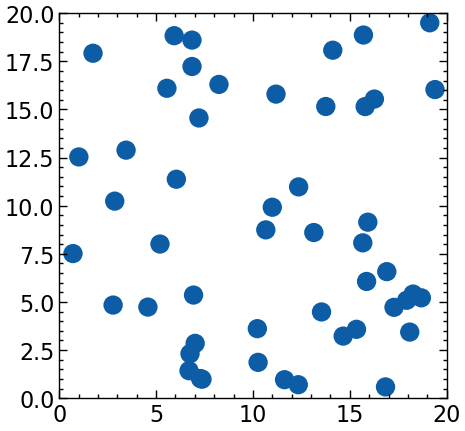

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
x, y = rs[0][0], rs[0][1]
circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi, yi in zip(x, y)]
circ = matplotlib.collections.PatchCollection(circles)
ax.add_collection(circ)
ax.set_xlim(0, box[0])
ax.set_ylim(0, box[1])
plt.show()

* Animating:

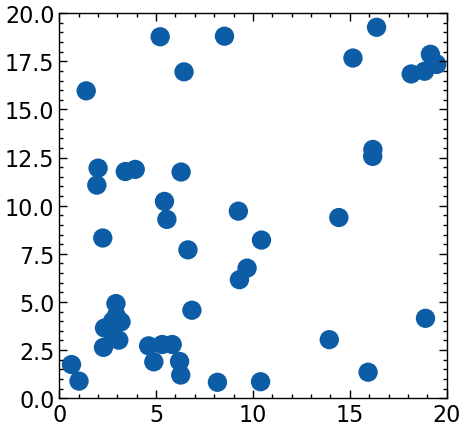

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

def animate(i):
    ax.clear()
    x, y = rs[i][0], rs[i][1]
    circles = [plt.Circle((xi, yi), radius=radius, linewidth=0) for xi,yi in zip(x,y)]
    circ = matplotlib.collections.PatchCollection(circles)
    ax.add_collection(circ)
    ax.set_xlim(0, box[0])
    ax.set_ylim(0, box[1])
    
ani = animation.FuncAnimation(fig, animate, frames=steps, interval=50)
ani.save('test10.gif', writer='pillow', fps=30, dpi=100)

* Maxwell-Boltzmann in 2 Dimensions:

* $kT = KE_{avg} = \frac{1}{2}m\bar{v^2} \implies \boxed{\frac{m}{kT} = \frac{2}{\bar{v^2}}}$
* $\boxed{f(v) = \frac{m}{kT} v \exp\left(-\frac{m}{kT}\frac{v^2}{2} \right)}$

* Distribution of velocities in the simulation and the boltzmann distribution with average v = 0.5 nm per numerical iteration step:

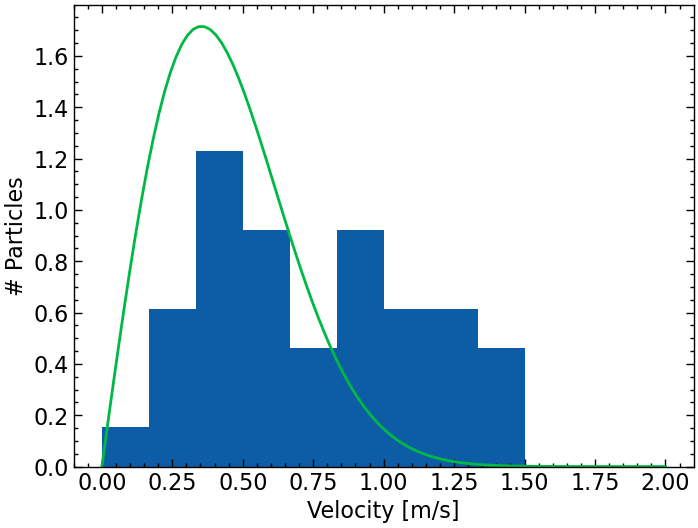

In [53]:
vv = np.linspace(0, vel * 4, 100)
a = 2/(vel**2)
fv = a*vv*np.exp(-a*vv**2 / 2)
bins = np.linspace(0, vel * 3, 10)
plt.figure()
plt.hist(np.sqrt(np.sum(vs[-1]**2, axis=0)), bins=bins, density=True)
plt.plot(vv, fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')
plt.show()

* Distribution of velocities in x axis and the boltzmann distribution with average v = 0.5 nm per numerical iteration step:

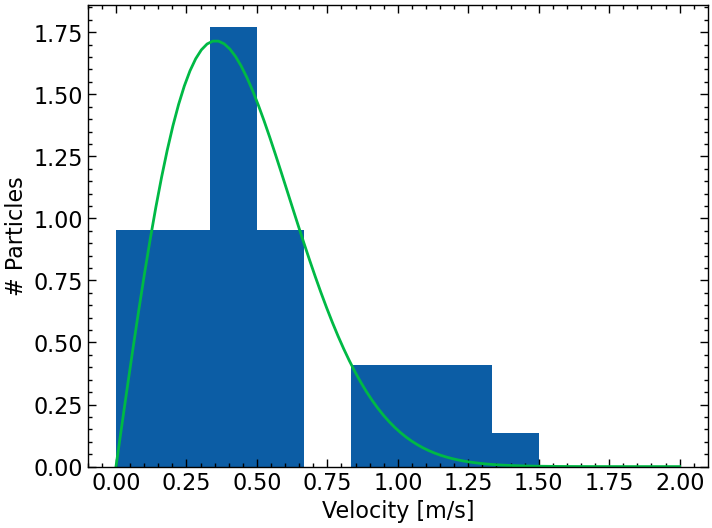

In [54]:
vv = np.linspace(0, vel * 4, 100)
a = 2/(vel**2)
fv = a*vv*np.exp(-a*vv**2 / 2)
bins = np.linspace(0, vel * 3, 10)
plt.figure()
plt.hist(np.abs(vs[-1][0]), bins=bins, density=True)
plt.plot(vv, fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')
plt.show()

* Distribution of velocities in y axis and the boltzmann distribution with average v = 0.5 nm per numerical iteration step:

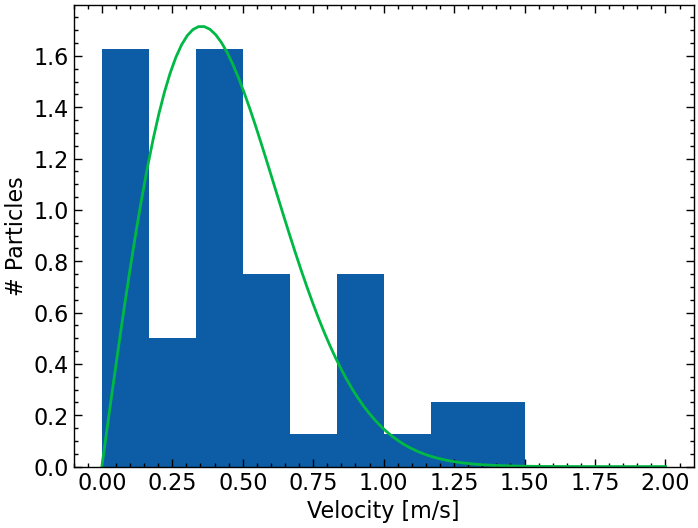

In [57]:
vv = np.linspace(0, vel * 4, 100)
a = 2/(vel**2)
fv = a*vv*np.exp(-a*vv**2 / 2)
bins = np.linspace(0, vel * 3, 10)
plt.figure()
plt.hist(np.abs(vs[-1][1]), bins=bins, density=True)
plt.plot(vv, fv)
plt.xlabel('Velocity [m/s]')
plt.ylabel('# Particles')
plt.show()

**Histogramming:**

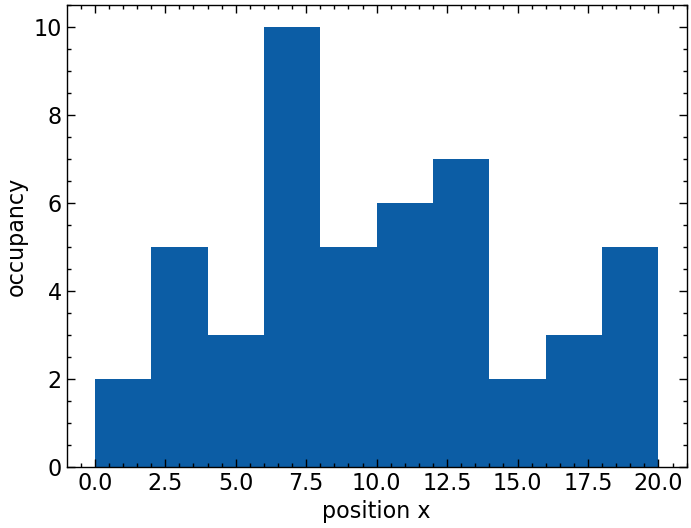

In [59]:
plt.hist(rs[-1][0], range=(0, box[0]), bins=10)
plt.xlabel('position x')
plt.ylabel('occupancy')
plt.show()

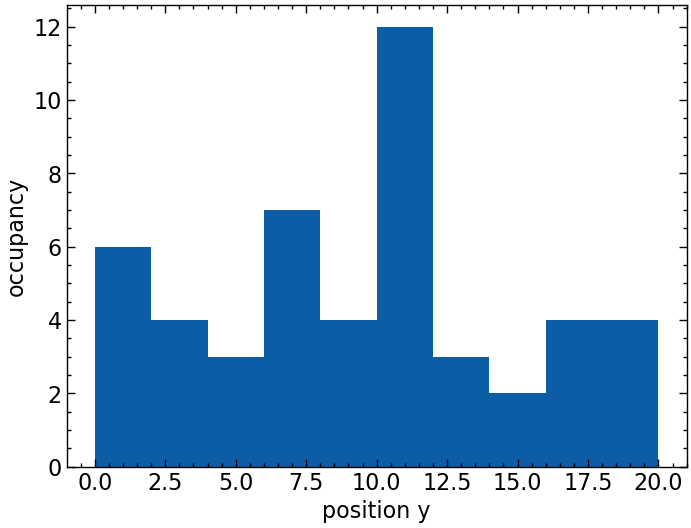

In [60]:
plt.hist(rs[-1][1], range=(0, box[0]), bins=10)
plt.xlabel('position y')
plt.ylabel('occupancy')
plt.show()

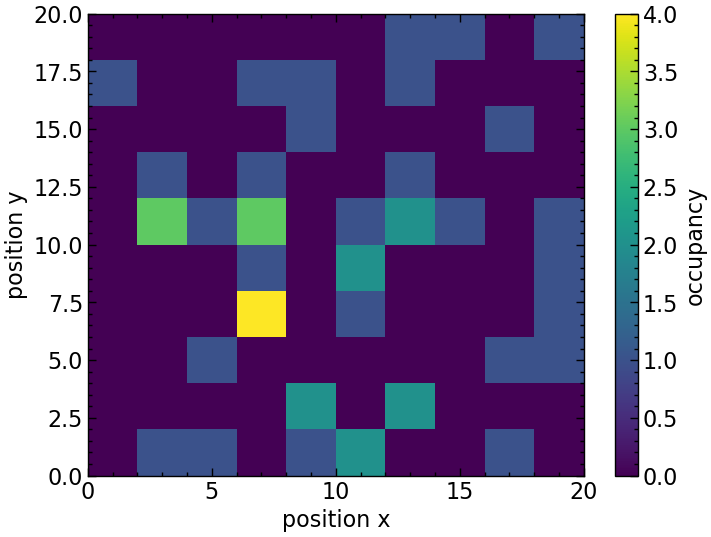

In [61]:
plt.hist2d(rs[-1][0], rs[-1][1], range=[[0, box[0]], [0, box[1]]], bins=10)
plt.xlabel('position x')
plt.ylabel('position y')
plt.colorbar().set_label('occupancy')
plt.show()